<a href="https://colab.research.google.com/github/Kim-matthew-0422/deeplearning-early-covid-detection-/blob/main/Inception_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!nvidia-smi -L
!mkdir ~/.kaggle
from google.colab import files
files.upload()

GPU 0: Tesla T4 (UUID: GPU-c6fd3d98-b6c0-82d7-eab2-1b8e569e94dd)


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"etkim422","key":"ba5083a771515c1999a723e17e69eb58"}'}

In [2]:
!cp kaggle.json ~/.kaggle/
!kaggle datasets download -d tawsifurrahman/covid19-radiography-database

100% 777M/778M [00:34<00:00, 24.2MB/s]
100% 778M/778M [00:34<00:00, 23.4MB/s]


In [3]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, compare_historys, walk_through_dir

--2023-01-26 07:49:30--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.108.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2023-01-26 07:49:30 (57.2 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [4]:
from sklearn.model_selection import train_test_split

In [5]:
unzip_data('covid19-radiography-database.zip')

In [6]:
path = 'COVID-19_Radiography_Dataset'
levels = ['Normal/images', 'COVID/images']

In [7]:
import os
data_dir = os.path.join(path) 

In [8]:
data_dir

'COVID-19_Radiography_Dataset'

In [9]:
import pandas as pd

data = []
for id, level in enumerate(levels):
    for file in os.listdir(os.path.join(data_dir, level)):
        data.append(['{}/{}'.format(level, file), level])
data = pd.DataFrame(data, columns = ['image_file', 'corona_result'])

In [10]:
data['path'] = path + '/' + data['image_file']
data['corona_result'] = data['corona_result'].map({'Normal/images': 'Negative', 'COVID/images': 'Positive'})
samples = 13808

data.head()

,image_file,corona_result,path
0,Normal/images/Normal-1069.png,Negative,COVID-19_Radiography_Dataset/Normal/images/Nor...
1,Normal/images/Normal-9632.png,Negative,COVID-19_Radiography_Dataset/Normal/images/Nor...
2,Normal/images/Normal-957.png,Negative,COVID-19_Radiography_Dataset/Normal/images/Nor...
3,Normal/images/Normal-3188.png,Negative,COVID-19_Radiography_Dataset/Normal/images/Nor...
4,Normal/images/Normal-1157.png,Negative,COVID-19_Radiography_Dataset/Normal/images/Nor...


In [11]:
import numpy as np
from keras.preprocessing import image
from PIL import Image
data['image'] = data['path'].map(lambda x: np.asarray(Image.open(x).resize((75,75))))

data.head()

,image_file,corona_result,path,image
0,Normal/images/Normal-1069.png,Negative,COVID-19_Radiography_Dataset/Normal/images/Nor...,"[[0, 0, 0, 0, 3, 34, 51, 66, 81, 91, 98, 97, 9..."
1,Normal/images/Normal-9632.png,Negative,COVID-19_Radiography_Dataset/Normal/images/Nor...,"[[5, 4, 4, 4, 3, 4, 3, 3, 3, 2, 2, 1, 1, 1, 1,..."
2,Normal/images/Normal-957.png,Negative,COVID-19_Radiography_Dataset/Normal/images/Nor...,"[[69, 45, 49, 55, 56, 58, 59, 57, 53, 47, 40, ..."
3,Normal/images/Normal-3188.png,Negative,COVID-19_Radiography_Dataset/Normal/images/Nor...,"[[10, 10, 7, 5, 3, 11, 17, 19, 25, 26, 29, 33,..."
4,Normal/images/Normal-1157.png,Negative,COVID-19_Radiography_Dataset/Normal/images/Nor...,"[[29, 46, 61, 66, 90, 118, 109, 109, 115, 127,..."


In [12]:
all_covid = []
all_normal = []
import random
from glob import glob
all_normal.extend(glob(os.path.join(path, 'Normal/images/*.png')))
all_covid.extend(glob(os.path.join(path, 'COVID/images/*.png')))

random.shuffle(all_normal)
random.shuffle(all_covid)

images = all_normal[:50] + all_covid[:50]

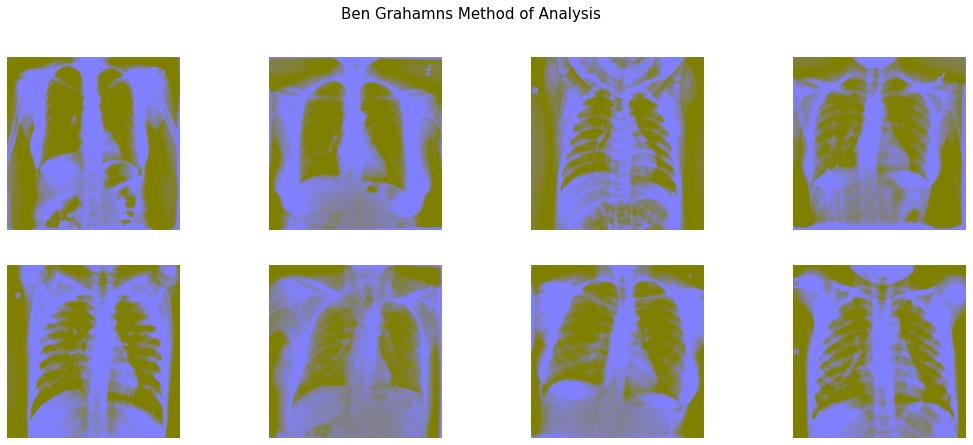

In [16]:
from matplotlib import pyplot as plt
import cv2
fig = plt.figure(figsize = (18, 7))
fig.suptitle("Ben Grahamns Method of Analysis", fontsize = 15)
columns = 4; rows = 2

for i in range(1, columns*rows +1):
    img = cv2.imread(images[i])
    img = cv2.resize(img, (512, 512))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    img = cv2.addWeighted (img, 4, cv2.GaussianBlur(img, (0,0), 512/10), -4, 128)
    fig.add_subplot(rows, columns, i)
    plt.imshow(img)
    plt.axis(False)

In [23]:
all_data = []


for i in range(len(data)):
  image = cv2.imread(data['path'][i])
  image = cv2.resize(image, (75,75)) / 255.0
  label = 1 if data['corona_result'][i] == 'Positive' else 0 
  all_data.append([image, label])

x = []
y = []

for image, label in all_data:
    x.append(image)
    y.append(label)

# Converting to Numpy Array    
x = np.array(x)
y = np.array(y)

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 42)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size = 0.1, random_state = 42)

print(x_train.shape, x_test.shape, x_val.shape, y_train.shape, y_test.shape, y_val.shape)

(9941, 75, 75, 3) (2762, 75, 75, 3) (1105, 75, 75, 3) (9941,) (2762,) (1105,)


In [19]:
from tensorflow.keras import layers, models
import tensorflow as tf

In [21]:
from tensorflow.keras.applications.inception_v3 import InceptionV3

In [24]:
base_model = InceptionV3(input_shape = (75,75,3),
                         include_top = False)
for layer in base_model.layers:
    layer.trainable = False

87910968/87910968 [==============================] - 5s 0us/step


In [26]:
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.models import Sequential
IN_model = Sequential()
IN_model.add(base_model)
IN_model.add(layers.Flatten())
IN_model.add(layers.Dense(units = 16, activation = 'relu'))
IN_model.add(layers.Dropout(0.2))
IN_model.add(layers.Dense(units = 2))

IN_model.compile(optimizer = 'adam',
                  loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True),
                  metrics = ['accuracy'])

In [28]:
es = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', mode = 'min', verbose = 1, patience = 4)
history_IN = IN_model.fit(x_train, y_train, 
                        epochs = 50, batch_size = 256,  
                        validation_data = (x_val, y_val), 
                        callbacks = [es])

Epoch 1/50
39/39 [==============================] - 19s 165ms/step - loss: 0.4837 - accuracy: 0.7752 - val_loss: 0.3890 - val_accuracy: 0.8136
Epoch 2/50
39/39 [==============================] - 2s 63ms/step - loss: 0.3977 - accuracy: 0.8212 - val_loss: 0.3565 - val_accuracy: 0.8416
Epoch 3/50
39/39 [==============================] - 2s 64ms/step - loss: 0.3653 - accuracy: 0.8428 - val_loss: 0.3513 - val_accuracy: 0.8498
Epoch 4/50
39/39 [==============================] - 2s 64ms/step - loss: 0.3412 - accuracy: 0.8533 - val_loss: 0.3344 - val_accuracy: 0.8579
Epoch 5/50
39/39 [==============================] - 2s 62ms/step - loss: 0.3226 - accuracy: 0.8633 - val_loss: 0.3279 - val_accuracy: 0.8552
Epoch 6/50
39/39 [==============================] - 2s 62ms/step - loss: 0.3090 - accuracy: 0.8730 - val_loss: 0.3294 - val_accuracy: 0.8624
Epoch 7/50
39/39 [==============================] - 2s 62ms/step - loss: 0.2905 - accuracy: 0.8823 - val_loss: 0.3164 - val_accuracy: 0.8661
Epoch 8/50


In [63]:
base_model = InceptionV3(input_shape = (75,75,3),
                         include_top = False)
# Unfreeze all of the layers in the base model
base_model.trainable = True

# Refreeze every layer except for the last 5
for layer in base_model.layers[:-10]:
  layer.trainable = False

In [64]:

IN_model_2 = Sequential()
IN_model_2.add(base_model)
IN_model_2.add(layers.Flatten())
IN_model_2.add(layers.Dense(units = 16, activation = 'relu'))
IN_model_2.add(layers.Dropout(0.2))
IN_model_2.add(layers.Dense(units = 2))
IN_model_2.compile(optimizer = 'adam',
                  loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True),
                  metrics = ['accuracy'])

In [65]:
# What layers in the model are trainable?
for layer in IN_model_2.layers:
  print(layer.name, layer.trainable)

inception_v3 True
flatten_8 True
dense_16 True
dropout_8 True
dense_17 True


In [66]:
# Check which layers are trainable
for layer_number, layer in enumerate(IN_model_2.layers):
  print(layer_number, layer.name, layer.trainable)

0 inception_v3 True
1 flatten_8 True
2 dense_16 True
3 dropout_8 True
4 dense_17 True


In [67]:
IN_model_2.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 1, 1, 2048)        21802784  
                                                                 
 flatten_8 (Flatten)         (None, 2048)              0         
                                                                 
 dense_16 (Dense)            (None, 16)                32784     
                                                                 
 dropout_8 (Dropout)         (None, 16)                0         
                                                                 
 dense_17 (Dense)            (None, 2)                 34        
                                                                 
Total params: 21,835,602
Trainable params: 33,010
Non-trainable params: 21,802,592
_________________________________________________________________


In [56]:
IN_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 1, 1, 2048)        21802784  
                                                                 
 flatten_3 (Flatten)         (None, 2048)              0         
                                                                 
 dense_6 (Dense)             (None, 16)                32784     
                                                                 
 dropout_3 (Dropout)         (None, 16)                0         
                                                                 
 dense_7 (Dense)             (None, 2)                 34        
                                                                 
Total params: 21,835,602
Trainable params: 32,818
Non-trainable params: 21,802,784
_________________________________________________________________


In [68]:
history_IN_trainable = IN_model_2.fit(x_train, y_train, 
                        epochs = 50, batch_size = 256,  
                        validation_data = (x_val, y_val), 
                        callbacks = [es])

Epoch 1/50
39/39 [==============================] - 8s 104ms/step - loss: 0.5663 - accuracy: 0.7135 - val_loss: 0.4352 - val_accuracy: 0.7683
Epoch 2/50
39/39 [==============================] - 2s 63ms/step - loss: 0.4581 - accuracy: 0.7679 - val_loss: 0.3895 - val_accuracy: 0.8145
Epoch 3/50
39/39 [==============================] - 2s 62ms/step - loss: 0.4103 - accuracy: 0.8141 - val_loss: 0.3756 - val_accuracy: 0.8308
Epoch 4/50
39/39 [==============================] - 2s 62ms/step - loss: 0.3795 - accuracy: 0.8283 - val_loss: 0.3509 - val_accuracy: 0.8380
Epoch 5/50
39/39 [==============================] - 2s 63ms/step - loss: 0.3643 - accuracy: 0.8398 - val_loss: 0.3428 - val_accuracy: 0.8534
Epoch 6/50
39/39 [==============================] - 2s 63ms/step - loss: 0.3445 - accuracy: 0.8501 - val_loss: 0.3299 - val_accuracy: 0.8643
Epoch 7/50
39/39 [==============================] - 2s 63ms/step - loss: 0.3362 - accuracy: 0.8574 - val_loss: 0.3248 - val_accuracy: 0.8688
Epoch 8/50
3